In [22]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import KFold

#AWS
import boto3
from botocore.exceptions import ClientError
from io import StringIO

In [3]:
def readfromS3(filename):
    path = 's3://lendingclubdatastore/'
    bucket = path + filename  # already created on S3
    client = boto3.resource('s3')
    df = pd.read_csv(bucket)
    return df

In [4]:
loans = readfromS3('loans_updated.csv')
loans.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,return
0,1,30000,30000,30000.0,36,22.35,1151.16,D,5.0,MORTGAGE,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.029381
1,2,20000,20000,20000.0,36,7.56,622.68,A,12.0,MORTGAGE,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.359654
2,3,4500,4500,4500.0,36,11.31,147.99,B,12.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.364571
3,4,20000,20000,20000.0,60,17.97,507.55,D,4.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.013577
4,5,6600,6600,6325.0,36,11.31,217.05,B,12.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.115197


In [5]:
loans.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag', 'settlement_status',
       'settlement_amount', 'settlement_percentage', 'settlement_term',
       'return'],
      dtype='object', length=126)

In [6]:
loans.columns[loans.isnull().any()]

Index([], dtype='object')

In [7]:
#train dataset label encoding
for i in ('grade','loan_status','home_ownership','verification_status','pymnt_plan','initial_list_status','application_type',
          'verification_status_joint','hardship_flag','hardship_reason','hardship_status','hardship_loan_status',
          'hardship_type','debt_settlement_flag','settlement_status','disbursement_method'):
    le = LabelEncoder()
    le.fit(loans[i])
    encoded = le.transform(loans[i])
    loans[i] = encoded

# Predicting interest rates for borrowers

<h2>Identifying correlation between dependent and independet variables</h2>

member_id                 0.082849
loan_amnt                 0.132673
funded_amnt               0.132726
funded_amnt_inv           0.132882
term                      0.394112
int_rate                  1.000000
installment               0.133627
grade                     0.950738
emp_length               -0.004883
home_ownership            0.071656
annual_inc               -0.073776
verification_status       0.254149
loan_status              -0.244912
pymnt_plan                     NaN
dti                       0.144580
delinq_2yrs               0.050999
inq_last_6mths            0.215632
mths_since_last_delinq   -0.021190
mths_since_last_record    0.005625
open_acc                 -0.011261
Name: int_rate, dtype: float64


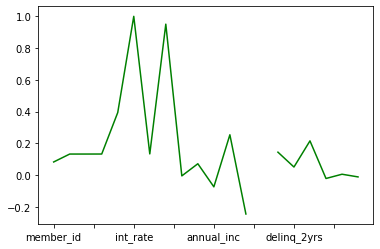

In [60]:
correlation = loans.corr()

(correlation['int_rate'][0:20]).plot(color='green')

print(correlation['int_rate'][0:20])

pub_rec                        0.052987
revol_bal                     -0.028612
revol_util                     0.260954
total_acc                     -0.044440
initial_list_status           -0.132657
out_prncp                      0.001910
out_prncp_inv                  0.001910
total_pymnt                    0.087369
total_pymnt_inv                0.087549
total_rec_prncp               -0.036387
total_rec_int                  0.409593
total_rec_late_fee             0.069210
recoveries                     0.175036
collection_recovery_fee        0.161099
last_pymnt_amnt                0.083078
collections_12_mths_ex_med     0.001102
mths_since_last_major_derog   -0.011888
policy_code                         NaN
application_type               0.023350
annual_inc_joint               0.015197
Name: int_rate, dtype: float64


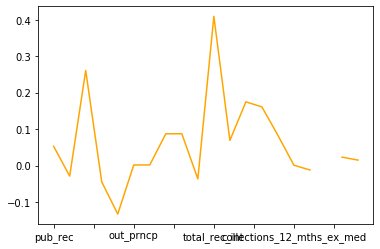

In [61]:
print(correlation['int_rate'][20:40])
(correlation['int_rate'][20:40]).plot(color='orange')

dti_joint                    0.032820
verification_status_joint    0.027070
acc_now_delinq               0.018350
tot_coll_amt                 0.002524
tot_cur_bal                 -0.088180
open_acc_6m                  0.066621
open_act_il                 -0.000110
open_il_12m                  0.077302
open_il_24m                  0.056074
mths_since_rcnt_il          -0.055203
total_bal_il                 0.020043
il_util                      0.085295
open_rv_12m                  0.089822
open_rv_24m                  0.094167
max_bal_bc                  -0.030060
all_util                     0.170065
total_rev_hi_lim            -0.166421
inq_fi                       0.084250
total_cu_tl                  0.008463
inq_last_12m                 0.115038
Name: int_rate, dtype: float64


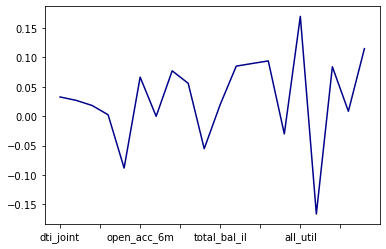

In [62]:
print(correlation['int_rate'][40:60])
(correlation['int_rate'][40:60]).plot(color='darkblue')

acc_open_past_24mths              0.174026
avg_cur_bal                      -0.084691
bc_open_to_buy                   -0.292576
bc_util                           0.267340
chargeoff_within_12_mths          0.012912
delinq_amnt                       0.005612
mo_sin_old_il_acct               -0.067848
mo_sin_old_rev_tl_op             -0.134698
mo_sin_rcnt_rev_tl_op            -0.105057
mo_sin_rcnt_tl                   -0.122260
mort_acc                         -0.078918
mths_since_recent_bc             -0.079965
mths_since_recent_bc_dlq         -0.002910
mths_since_recent_inq            -0.156207
mths_since_recent_revol_delinq   -0.005961
num_accts_ever_120_pd             0.041665
num_actv_bc_tl                    0.021701
num_actv_rev_tl                   0.087733
num_bc_sats                      -0.058353
num_bc_tl                        -0.079355
Name: int_rate, dtype: float64


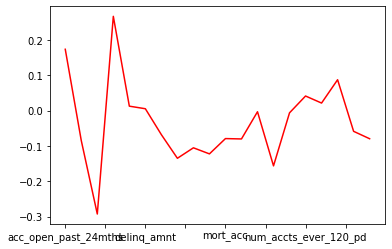

In [63]:
print(correlation['int_rate'][60:80])
(correlation['int_rate'][60:80]).plot(color='red')

num_il_tl                     0.005565
num_op_rev_tl                -0.012549
num_rev_accts                -0.054024
num_rev_tl_bal_gt_0           0.087652
num_sats                     -0.016485
num_tl_120dpd_2m              0.006751
num_tl_30dpd                  0.014711
num_tl_90g_dpd_24m            0.027994
num_tl_op_past_12m            0.192899
pct_tl_nvr_dlq               -0.066613
percent_bc_gt_75              0.263080
pub_rec_bankruptcies          0.058504
tax_liens                     0.011590
tot_hi_cred_lim              -0.122676
total_bal_ex_mort            -0.004201
total_bc_limit               -0.238961
total_il_high_credit_limit   -0.013310
revol_bal_joint               0.017565
sec_app_inq_last_6mths        0.016789
sec_app_mort_acc              0.002055
Name: int_rate, dtype: float64


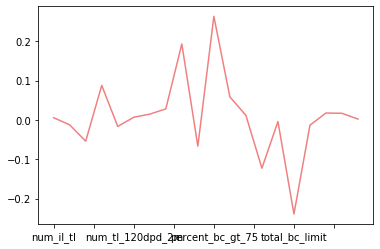

In [64]:
print(correlation['int_rate'][80:100])
(correlation['int_rate'][80:100]).plot(color='lightcoral')

sec_app_open_acc                              0.013744
sec_app_revol_util                            0.027280
sec_app_open_act_il                           0.012884
sec_app_num_rev_accts                         0.009993
sec_app_chargeoff_within_12_mths              0.006368
sec_app_collections_12_mths_ex_med            0.010287
sec_app_mths_since_last_major_derog           0.012079
hardship_flag                                -0.001561
hardship_type                                -0.024597
hardship_reason                              -0.015863
hardship_status                              -0.024793
deferral_term                                      NaN
hardship_amount                               0.040919
hardship_length                               0.024597
hardship_dpd                                  0.023280
hardship_loan_status                         -0.020809
orig_projected_additional_accrued_interest    0.027501
hardship_payoff_balance_amount                0.029959
hardship_l

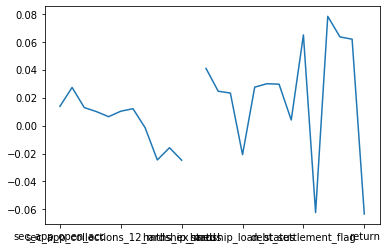

In [49]:
print(correlation['int_rate'][100:126])
(correlation['int_rate'][100:126]).plot()

<h2> interest rate is dependent variable and remaining highly correlated features independent variables </h2>

In [15]:
X = loans[['loan_amnt','funded_amnt','funded_amnt_inv','term','installment','grade','verification_status','loan_status','dti',
'inq_last_6mths','revol_util','initial_list_status','total_rec_int','all_util','total_rev_hi_lim','acc_open_past_24mths',
'bc_open_to_buy','bc_util','mths_since_recent_inq','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_bc_limit',
]]

Y = loans['int_rate']

<h2>Train and test the linear regression with 75% for training set and 25% for testing set</h2>

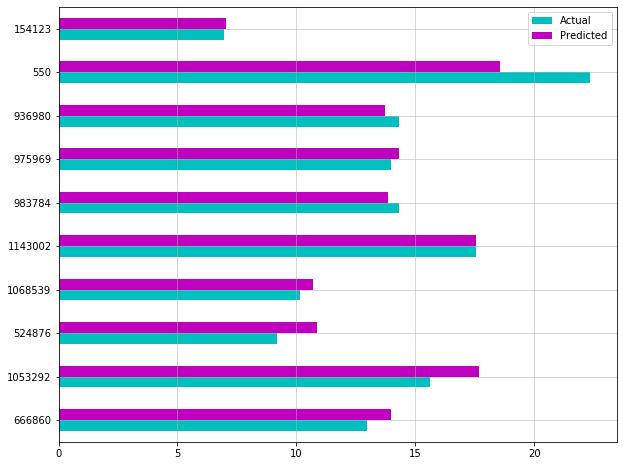

***************Evaluation*****************
Slope: [-5.50552596e+00 -1.23891393e+01  6.90640735e+00  2.10078765e+00
  1.38804660e+01  1.80157494e+01  2.65640081e-01 -6.31107474e-02
  1.35348311e+00  7.91546212e-01  7.44597829e-01 -2.22781384e-01
  1.10554324e+00  9.01243390e-01 -2.62528502e+00  2.39507961e-01
 -1.64585835e+00  4.40577731e-02 -4.95692310e-04  5.11929262e-01
  1.62557951e-01 -2.79200884e+00 -1.71640826e+00]
Intercept: 7.009035326763447
Root mean squared error:  1.6278779539041834
Accuracy: 98.37 %
R2 score:  0.9145499116791761


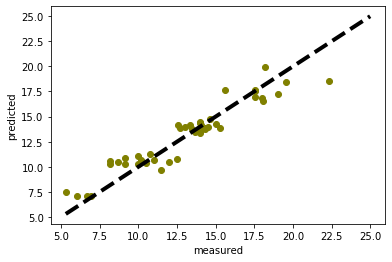

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=42)

lm = LinearRegression()
lm.fit(X_train,Y_train)

#Prediction
Y_predicted = lm.predict(X_test)

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)


#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['c','m'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

print("***************Evaluation*****************")

# model evaluation
rmse = metrics.mean_squared_error(Y_test, Y_predicted)
r2 = metrics.r2_score(Y_test, Y_predicted)

# printing values
print('Slope:' ,lm.coef_)
print('Intercept:', lm.intercept_)
print('Root mean squared error: ', rmse)
print('Accuracy: {} %'.format(round((100-rmse),2)))
print('R2 score: ', r2)

#plotting the values
fig, ax = plt.subplots()
ax.scatter(Y_test[:50], Y_predicted[:50], color='olive')
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

<h3><i>The model is overfitting with 98.37% accuracy </i></h3>

<h2> We use K-fold cross validation to remove the bias</h2>

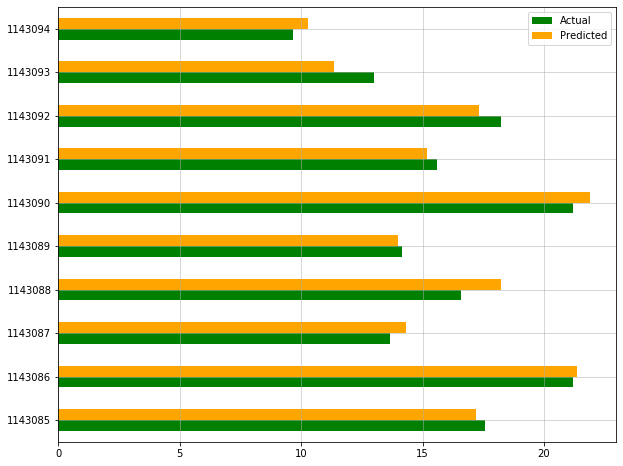

***************Evaluation*****************
Slope: [ -2.08271336 -18.69782877   9.40274885   2.20519095  14.28545983
  18.1071447    0.27537246  -0.05294619   0.06271926   0.81348314
   1.62759189  -0.27335262   1.16753519   0.85404938  -2.13780538
   0.22558942  -1.5032971   -0.20598661   0.02351095   0.45358387
   0.14237107  -2.47145426  -1.14580141]
Intercept: 6.974804794249101
Root mean squared error:  2.089258251451075
Accuracy: 97.91 %
R2 score:  0.8838675102193352


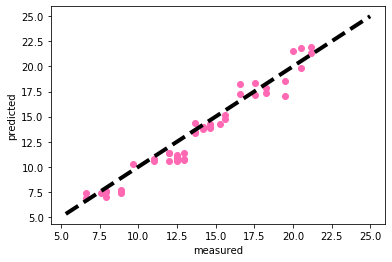

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    
lm = LinearRegression()
lm.fit(X_train,Y_train)

#Prediction
Y_predicted = lm.predict(X_test)

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)


#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['green','orange'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

print("***************Evaluation*****************")

# model evaluation
rmse = metrics.mean_squared_error(Y_test, Y_predicted)
r2 = metrics.r2_score(Y_test, Y_predicted)

# printing values
print('Slope:' ,lm.coef_)
print('Intercept:', lm.intercept_)
print('Root mean squared error: ', rmse)
print('Accuracy: {} %'.format(round((100-rmse),2)))
print('R2 score: ', r2)

#plotting the values
fig, ax = plt.subplots()
ax.scatter(Y_test[:50], Y_predicted[:50], color='hotpink')
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

<h2> Principal Component Analysis </h2>

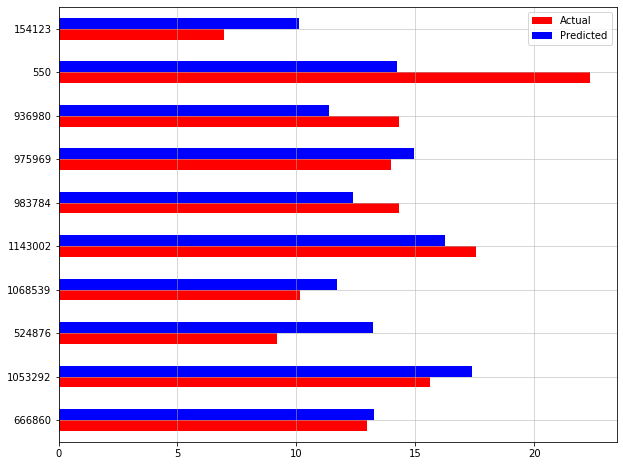

***************Evaluation*****************
Slope: [3.06025577 2.5959181 ]
Intercept: 12.984750590509028
Root mean squared error:  14.555096524477431
Accuracy: 85.44 %
R2 score:  0.23597817603473759


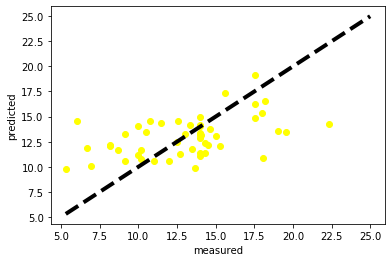

In [57]:
pca = PCA(n_components = 2) 
  
n_X_train = pca.fit_transform(X_train) 
n_X_test = pca.transform(X_test) 


lm = LinearRegression()
lm.fit(n_X_train,Y_train)

#Prediction
Y_predicted = lm.predict(n_X_test)

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)


#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['red','blue'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()


print("***************Evaluation*****************")

# model evaluation
rmse = metrics.mean_squared_error(Y_test, Y_predicted)
r2 = metrics.r2_score(Y_test, Y_predicted)

# printing values
print('Slope:' ,lm.coef_)
print('Intercept:', lm.intercept_)
print('Root mean squared error: ', rmse)
print('Accuracy: {} %'.format(round((100-rmse),2)))
print('R2 score: ', r2)

#plotting the values
fig, ax = plt.subplots()
ax.scatter(Y_test[:50], Y_predicted[:50], color='yellow')
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

# Predicting the returns for investors

<h2>Identifying correlation between dependent and independet variables</h2>

member_id                 0.123504
loan_amnt                -0.024642
funded_amnt              -0.024841
funded_amnt_inv          -0.024661
term                     -0.064600
int_rate                 -0.063304
installment              -0.015988
grade                    -0.064168
emp_length                0.021748
home_ownership           -0.047559
annual_inc                0.016904
verification_status      -0.021098
loan_status               0.841917
pymnt_plan                     NaN
dti                      -0.050434
delinq_2yrs              -0.004019
inq_last_6mths           -0.022998
mths_since_last_delinq    0.000430
mths_since_last_record   -0.009440
open_acc                 -0.026115
Name: return, dtype: float64


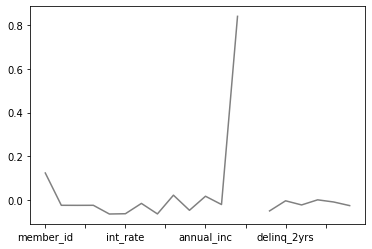

In [66]:
correlation = loans.corr()

(correlation['return'][0:20]).plot(kind='line',color='gray')

print(correlation['return'][0:20])

pub_rec                       -0.015007
revol_bal                      0.018091
revol_util                     0.043136
total_acc                     -0.001340
initial_list_status           -0.077760
out_prncp                     -0.007468
out_prncp_inv                 -0.007468
total_pymnt                    0.385562
total_pymnt_inv                0.384857
total_rec_prncp                0.427031
total_rec_int                  0.216277
total_rec_late_fee            -0.064132
recoveries                    -0.359846
collection_recovery_fee       -0.333722
last_pymnt_amnt                0.199432
collections_12_mths_ex_med    -0.004564
mths_since_last_major_derog   -0.002206
policy_code                         NaN
application_type              -0.052820
annual_inc_joint              -0.043334
Name: return, dtype: float64


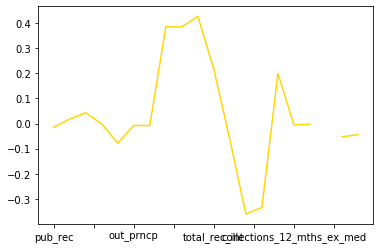

In [67]:
(correlation['return'][20:40]).plot(kind='line',color='gold')

print(correlation['return'][20:40])

dti_joint                   -0.055588
verification_status_joint   -0.054392
acc_now_delinq               0.001055
tot_coll_amt                 0.000268
tot_cur_bal                  0.036563
open_acc_6m                 -0.131744
open_act_il                 -0.114876
open_il_12m                 -0.116664
open_il_24m                 -0.136628
mths_since_rcnt_il           0.010283
total_bal_il                 0.006101
il_util                     -0.014804
open_rv_12m                 -0.026041
open_rv_24m                 -0.035986
max_bal_bc                   0.018035
all_util                    -0.016606
total_rev_hi_lim             0.004981
inq_fi                      -0.021423
total_cu_tl                  0.005283
inq_last_12m                -0.025169
Name: return, dtype: float64


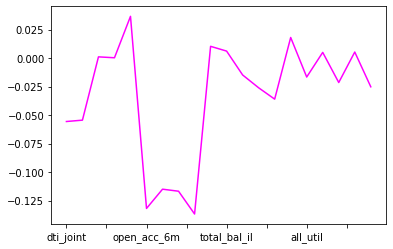

In [68]:
(correlation['return'][40:60]).plot(kind='line',color='magenta')

print(correlation['return'][40:60])

acc_open_past_24mths             -0.089433
avg_cur_bal                       0.042585
bc_open_to_buy                   -0.009151
bc_util                           0.040129
chargeoff_within_12_mths         -0.002384
delinq_amnt                      -0.003505
mo_sin_old_il_acct                0.021715
mo_sin_old_rev_tl_op              0.030407
mo_sin_rcnt_rev_tl_op             0.035154
mo_sin_rcnt_tl                    0.041342
mort_acc                          0.053186
mths_since_recent_bc              0.041397
mths_since_recent_bc_dlq          0.006298
mths_since_recent_inq             0.035688
mths_since_recent_revol_delinq    0.004219
num_accts_ever_120_pd            -0.002514
num_actv_bc_tl                   -0.012501
num_actv_rev_tl                  -0.017564
num_bc_sats                      -0.023338
num_bc_tl                         0.009498
Name: return, dtype: float64


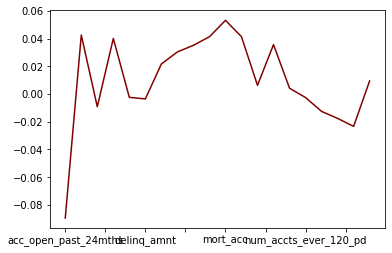

In [69]:
(correlation['return'][60:80]).plot(kind='line',color='maroon')

print(correlation['return'][60:80])

num_il_tl                    -0.014519
num_op_rev_tl                -0.024749
num_rev_accts                 0.000496
num_rev_tl_bal_gt_0          -0.013762
num_sats                     -0.023278
num_tl_120dpd_2m             -0.000026
num_tl_30dpd                  0.001963
num_tl_90g_dpd_24m           -0.001974
num_tl_op_past_12m           -0.069728
pct_tl_nvr_dlq               -0.010945
percent_bc_gt_75              0.031115
pub_rec_bankruptcies         -0.020847
tax_liens                    -0.002859
tot_hi_cred_lim               0.034760
total_bal_ex_mort            -0.003631
total_bc_limit                0.005357
total_il_high_credit_limit   -0.011086
revol_bal_joint              -0.043176
sec_app_inq_last_6mths       -0.047837
sec_app_mort_acc             -0.024706
Name: return, dtype: float64


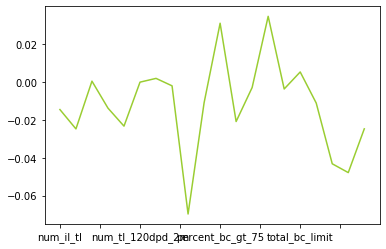

In [70]:
(correlation['return'][80:100]).plot(kind='line',color='yellowgreen')

print(correlation['return'][80:100])

sec_app_open_acc                             -0.048101
sec_app_revol_util                           -0.055202
sec_app_open_act_il                          -0.039638
sec_app_num_rev_accts                        -0.044495
sec_app_chargeoff_within_12_mths             -0.016973
sec_app_collections_12_mths_ex_med           -0.026327
sec_app_mths_since_last_major_derog          -0.028187
hardship_flag                                -0.002197
hardship_type                                 0.044591
hardship_reason                               0.022625
hardship_status                               0.051534
deferral_term                                      NaN
hardship_amount                              -0.043525
hardship_length                              -0.044591
hardship_dpd                                 -0.042553
hardship_loan_status                          0.036959
orig_projected_additional_accrued_interest   -0.011590
hardship_payoff_balance_amount               -0.047703
hardship_l

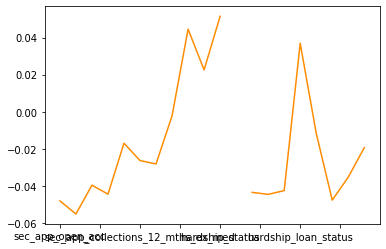

In [71]:
(correlation['return'][100:120]).plot(kind='line',color='darkorange')

print(correlation['return'][100:120])

debt_settlement_flag    -0.166942
settlement_status        0.172436
settlement_amount       -0.155051
settlement_percentage   -0.165856
settlement_term         -0.165322
return                   1.000000
Name: return, dtype: float64


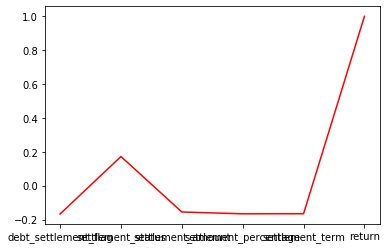

In [72]:
(correlation['return'][120:126]).plot(kind='line',color='red')

print(correlation['return'][120:126])

<h2> returns is the dependent variable and remaining highly correrlated variables are independent variables </h2>

In [73]:
X = loans[['loan_status','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','recoveries','collection_recovery_fee',
'last_pymnt_amnt','open_acc_6m','open_act_il','open_il_12m','open_il_24m','debt_settlement_flag','settlement_status',
'settlement_amount','settlement_percentage','settlement_term']]

Y = loans['return']

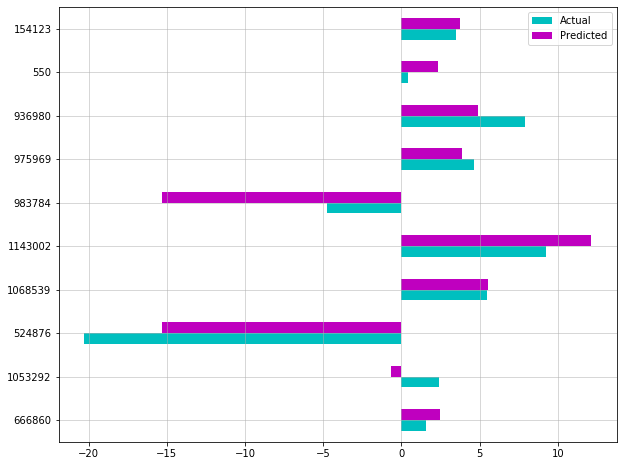

***************Evaluation*****************
Slope: [ 2.01033285e+01  1.56996034e-02 -3.06638367e-06 -1.57679157e-02
 -1.46972339e-02 -1.58880739e-02  2.68402853e-03 -1.34631044e-04
 -2.03995444e-01 -7.07214652e-02  1.00947219e-01 -1.98646758e-01
  1.02873670e+01  1.86462590e+00 -8.77017767e-04  8.65141259e-02
 -1.06263830e-01]
Intercept: -21.312670331324494
Root mean squared error:  12.223559216296263
Accuracy: 87.78 %
R2 score:  0.8177673414227369


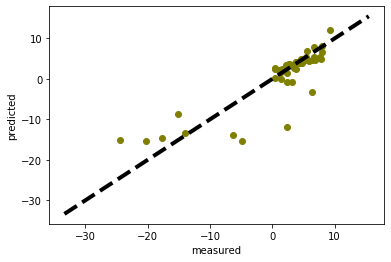

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=42)

lm = LinearRegression()
lm.fit(X_train,Y_train)

#Prediction
Y_predicted = lm.predict(X_test)

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)


#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['c','m'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

print("***************Evaluation*****************")

# model evaluation
rmse = metrics.mean_squared_error(Y_test, Y_predicted)
r2 = metrics.r2_score(Y_test, Y_predicted)

# printing values
print('Slope:' ,lm.coef_)
print('Intercept:', lm.intercept_)
print('Root mean squared error: ', rmse)
print('Accuracy: {} %'.format(round((100-rmse),2)))
print('R2 score: ', r2)

#plotting the values
fig, ax = plt.subplots()
ax.scatter(Y_test[:50], Y_predicted[:50], color='olive')
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()